# Задание 2

In [1]:
import pandas as pd
import nltk
import spacy
from nltk.tokenize import PunktSentenceTokenizer, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import warnings
import re
from gensim import corpora, models, similarities
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

# nltk.download('punkt')
#nltk.download('stopwords')

warnings.filterwarnings("ignore")

In [2]:
class BbcDataset(object):
    def __init__(self):
        self.DATA_DIR = "bbc/"
        self.classes = os.listdir(self.DATA_DIR)
        self.n_documents = len([os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files])

    def get_dataset(self):
        data = []
        for file in [os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files]:
            label = file.split("/")[-2]
            content = " ".join(open(file, encoding='utf-8', errors='ignore').read().splitlines())
            data.append((content, label))
        return data

    def get_pandas_alike_dataset(self):
        data = self.get_dataset()
        return pd.DataFrame(data, columns=["text", "label"])

In [3]:
df = BbcDataset().get_pandas_alike_dataset()
df = df[df.label != "bbc"]
df['label'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

In [4]:
class DataPreproces(object):
    def __init__(self, df, df_text):
        self.df = df
        self.df_text = df_text
        self.regex = re.compile("[A-Za-z]+")
        self.mystopwords = stopwords.words('english') 
        self.additional_stop_words = ['say','go','come','get','see','use','take','want','tell','need','also','people','year','good','include','new']

    def words_only(self, text):
        return " ".join(self.regex.findall(text))

    def remove_stopwords(self, text):
        try:
            return " ".join([token for token in text.split() if not token in self.mystopwords])
        except:
            return ""

    def parse_filter_document(self, text):
        filtered_doc = []
        for token in text:
            if token.is_stop == False | token.is_punct == False | token.is_space == False:
                if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
                    if token.lemma_ not in self.additional_stop_words:
                        filtered_doc.append(token.lemma_)

        return ' '.join(filtered_doc)
    
    def final_dataset(self):
        self.df_text = self.df_text.str.lower()
        self.df_text = self.df_text.apply(self.words_only)
        self.df_text = self.df_text.apply(self.remove_stopwords)
        
        nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
        
        self.df['processed_text'] = self.df_text.apply(lambda x: self.parse_filter_document(nlp(x)))
        
        data = self.df[['processed_text','label']]
        
        return data
        

In [5]:
data = DataPreproces(df, df.text).final_dataset()
data

,processed_text,label
1,musician tackle red tape musician group tackle...,entertainment
2,desire number prestigious award hit vertigo st...,entertainment
3,rocker doherty stage fight rock singer pete do...,entertainment
4,snicket top chart film lemony snicket novel to...,entertainment
5,ocean crime caper sequel star straight number ...,entertainment
...,...,...
2221,warn window word file write word document dang...,tech
2222,fast lift rise record book high speed lift wor...,tech
2223,add medium playing nintendo release handheld c...,tech
2224,fast move phone virus appear security firm war...,tech


In [6]:
class Topics(object):
    def __init__(self):
        self.classes = ['entertainment', 'business', 'sport', 'politics', 'tech']
    
    def dictionary_corpus(self, df):
        texts = [df.processed_text.iloc[i].split() for i in range(len(df))]
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]
        return dictionary, corpus

    def get_list(self):
        print("Topics for each class: \n")
        
        for i in self.classes:
            df_name = i + '_df'
            texts = i + '_texts'
            locals()[df_name] = data[data.label == i]
            
        for i in self.classes:
            dictionary = i + '_dic'
            corpus = i + '_corp'
            locals()[dictionary], locals()[corpus] = self.dictionary_corpus(locals()[i + '_df'])
            
        topic_list = []
        word_list = []

        for i in self.classes:
            corpus = i + '_corp'
            dictionary = i + '_dic'
            lda_model = i + '_lda'
            locals()[lda_model] = models.ldamodel.LdaModel(corpus=locals()[corpus],
                                                       id2word=locals()[dictionary],
                                                       num_topics=1, 
                                                       random_state=100,
                                                       update_every=1,
                                                       chunksize=100,
                                                       passes=10,
                                                       alpha='auto',
                                                       per_word_topics=True)

            words = locals()[lda_model].show_topics(formatted=False)
            word_list.append(words)
            one_topic_list = []
            one_probability_list = []
            for j in range(len(words[0][1])):
                one_probability_list.append(tuple([words[0][1][j][0],words[0][1][j][1]]))
                one_topic_list.append(words[0][1][j][0])
            topic_list.append((i,one_probability_list))
            
            print("Topic", i, ": ",", ".join(one_topic_list), "\n")
        
        return topic_list

In [7]:
topic_list = Topics().get_list()


Topics for each class: 

Topic entertainment :  film, music, award, song, star, band, actor, number, play, album 

Topic business :  market, firm, company, rise, price, economy, rate, sale, business, growth 

Topic sport :  game, play, time, win, player, team, match, second, half, test 

Topic politics :  government, election, labour, party, plan, right, tory, issue, claim, law 

Topic tech :  user, itune, file, security, music, firm, version, problem, game, program 



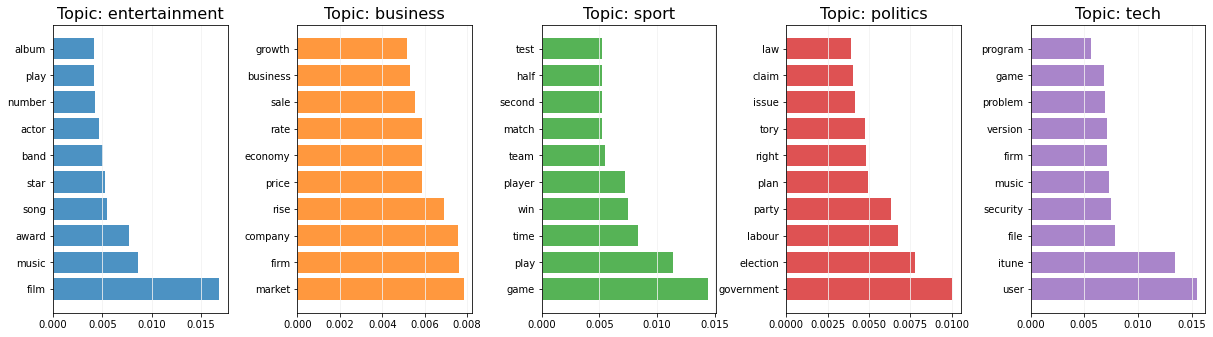

In [8]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
mystopwords = stopwords.words('english') 

cloud = WordCloud(stopwords=mystopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1,5 , figsize=(20,5))
 
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topic_list[i][1])
    ax.barh(list(topic_words.keys()),list(topic_words.values()), color=cols[i], alpha= 0.8)
    plt.gca().set_title('Topic: ' + topic_list[i][0], fontdict=dict(size=16))
    ax.grid(axis='x', color='0.95')

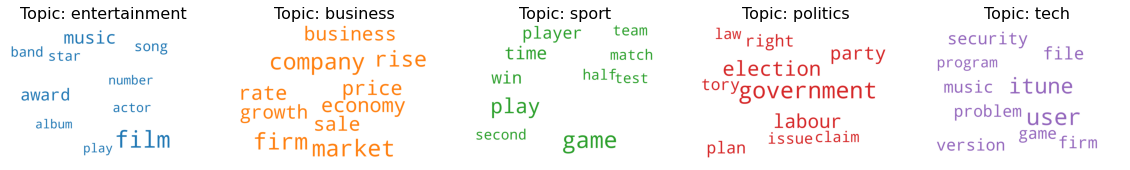

In [9]:
fig, axes = plt.subplots(1,5 , figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topic_list[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic: ' + topic_list[i][0], fontdict=dict(size=16))
    plt.gca().axis('off')

# Вывод 

Из визуализаций видно, что: 
- В классе Entertainment больше всего говорится о фильмах, музыке (также новых песнях и альбомах), премиях (наградах), звездах (например, актерах и группах).
- В классе Business больше всего говорится о рынках сбыта, компаниях, экономике, бизнесе, а также о связанных понятиях (например, ценах, продажах с торгов, ставках доходности).
- В классе Sport больше всего говорится об играх и матчах, их описании и результатах (участвующие команды, игроки, счет и время, кто победил).
- В классе Politics больше всего говорится о правительстве, выборах, политической партии Labour Party и членах партии, а также о связанных юридических понятиях (права, законы, претензии).
- В классе Tech больше всего говорится о пользователях, iTunes, а также о файлах, программах и играх, новых версиях, проблемах и безопасности. 